In [2]:
import sys
import nltk
import sklearn
import pandas
import numpy

import pandas as pd
import numpy as np

# load the dataset of Reviews
df = pd.read_csv('deceptive-opinion.csv',sep=",")

# check class distribution
classes = df.loc[:,"deceptive"]

from sklearn.preprocessing import LabelEncoder

# convert class labels to binary values 
encoder = LabelEncoder()
Y = encoder.fit_transform(classes)

text_messages = df.loc[:,"text"]

# Replace email addresses with 'email'
processed = text_messages.str.replace(r'^.+@[^\.].*\.[a-z]{2,}$',
                                 'emailaddress')

# Replace URLs with 'webaddress'
processed = processed.str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',
                                  'webaddress')

# Replace money symbols with 'moneysymb' (£ can by typed with ALT key + 156)
processed = processed.str.replace(r'£|\$', 'moneysymb')
    
# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
processed = processed.str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',
                                  'phonenumbr')
    
# Replace numbers with 'numbr'
processed = processed.str.replace(r'\d+(\.\d+)?', 'numbr')

# Remove punctuation
processed = text_messages.str.replace(r'[^\w\d\s]', ' ')

# Replace whitespace between terms with a single space
processed = processed.str.replace(r'\s+', ' ')

# Remove leading and trailing whitespace
processed = processed.str.replace(r'^\s+|\s+?$', '')

processed = processed.str.lower()

from nltk.corpus import stopwords

# remove stop words from review text

stop_words = set(stopwords.words('english'))

processed = processed.apply(lambda x: ' '.join(
    term for term in x.split() if term not in stop_words))

# Remove word stems using a Porter stemmer
ps = nltk.PorterStemmer()

processed = processed.apply(lambda x: ' '.join(
    ps.stem(term) for term in x.split()))


# create bag-of-words
from nltk.tokenize import word_tokenize

all_words = []
for message in processed:
    words = word_tokenize(message)
    for w in words:
        all_words.append(w)

all_words = nltk.FreqDist(all_words)
format(all_words.most_common(15))
word_features = list(all_words.keys())[:1500]

def find_features(message):
    words = word_tokenize(message)
    features = {}
    for word in word_features:
        features[word] = (word in words)

    return features

# Now lets do it for all the reviews
messages = list(zip(processed, Y))


# call find_features function for each review
featuresets = [(find_features(text), label) for (text, label) in messages]

# we can split the featuresets into training and testing datasets using sklearn
from sklearn import model_selection

# split the data into training and testing datasets
training, testing = model_selection.train_test_split(featuresets, test_size = 0.25, random_state=42)

from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Define models to train
names = ["Naive Bayes","Logistic Regression","SVM Linear"
        ]

classifiers = [
        MultinomialNB(),LogisticRegression(),SVC(kernel = 'linear')
]

models = zip(names, classifiers)

for name, model in models:
    nltk_model = SklearnClassifier(model)
    nltk_model.train(training)
    accuracy = nltk.classify.accuracy(nltk_model, testing)*100
    print("{} Accuracy: {}".format(name, accuracy))
    
# Ensemble methods - Voting classifier
from sklearn.ensemble import VotingClassifier

names = ["Naive Bayes","Logistic Regression", "SVM Linear"
        ]

classifiers = [ MultinomialNB(),LogisticRegression(),SVC(kernel = 'linear')
              ]

models = list(zip(names, classifiers))

nltk_ensemble = SklearnClassifier(VotingClassifier(estimators = models, voting = 'hard', n_jobs = -1))
nltk_ensemble.train(training)
accuracy = nltk.classify.accuracy(nltk_model, testing)*100
print("Voting Classifier: Accuracy: {}".format(accuracy))

Naive Bayes Accuracy: 89.0


C:\Users\Isha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression Accuracy: 87.0
SVM Linear Accuracy: 84.25
Voting Classifier: Accuracy: 84.25


In [3]:
# make class label prediction for testing set
txt_features, labels = zip(*testing)

prediction = nltk_ensemble.classify_many(txt_features)

# print a confusion matrix and a classification report
print(classification_report(labels, prediction))

pd.DataFrame(
    confusion_matrix(labels, prediction),
    index = [['actual', 'actual'], ['truthful', 'deceptive']],
    columns = [['predicted', 'predicted'], ['truthful', 'deceptive']])

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       206
           1       0.85      0.91      0.88       194

   micro avg       0.88      0.88      0.88       400
   macro avg       0.88      0.88      0.88       400
weighted avg       0.88      0.88      0.88       400



predicted          
                  truthful deceptive
actual truthful        175        31
       deceptive        18       176

In [4]:
print(text_messages[800])
print(processed[800])
test = find_features(processed[800])
prediction = nltk_ensemble.classify(test)
print(prediction)
print(Y[800])

Booked a room w/ a queen bed for 2 nights for a wonderful NYE, and was rather disappointed. Bed was either the world's smallest queen, or was actually a double, not to mention it was uncomfortably springy. Some of the things in the bathroom had been previously opened and used (q-tips). Lots of noise seemed to carry through the vents as we could hear other rooms rather clearly. When the tv was off, there was a very audible high-pitched humming noise that we could not get rid of unless we unplugged the tv. Hot water was very inconsistent in the shower. It is in a great location, however, next time I will try one of the other hotels in the area like the Intercontinental or Marriott. This might not be too bad if you are passing though quickly on business, but I wouldn't recommend it for a romantic night or two.

book room w queen bed 2 night wonder nye rather disappoint bed either world smallest queen actual doubl mention uncomfort springi thing bathroom previous open use q tip lot nois se

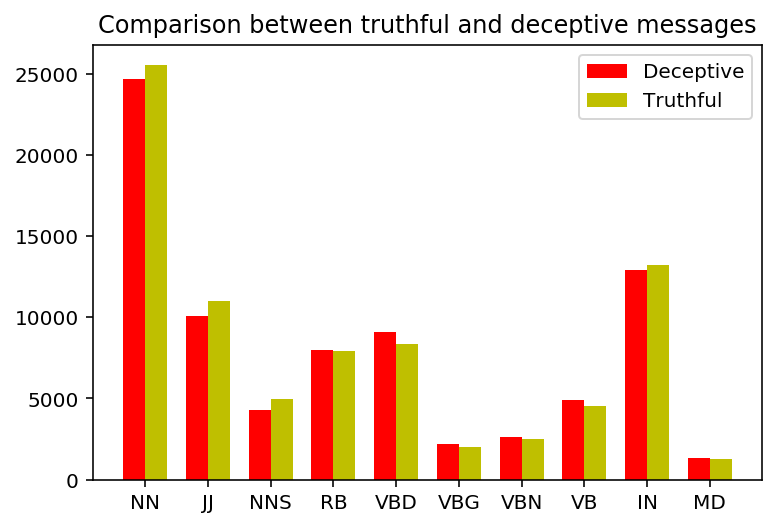

In [7]:
spam_text = df.loc[df['deceptive'] == "deceptive", "text"]
truth_text = df.loc[df['deceptive'] == "truthful", "text"]
# Remove punctuation
ptext = spam_text.str.replace(r'[^\w\d\s]', ' ')
ttext = truth_text.str.replace(r'[^\w\d\s]', ' ')
# Replace whitespace between terms with a single space
ptext = ptext.str.replace(r'\s+', ' ')
ttext = ttext.str.replace(r'\s+', ' ')
# Remove leading and trailing whitespace
ptext = ptext.str.replace(r'^\s+|\s+?$', '')
ttext = ttext.str.replace(r'^\s+|\s+?$', '')

ptext= ptext.str.lower()
ttext= ttext.str.lower()

#ptext = ptext.apply(lambda x: ' '.join(
#    term for term in x.split() if term not in stop_words))

#ttext = ttext.apply(lambda x: ' '.join(
#    term for term in x.split() if term not in stop_words))
# Remove word stems using a Porter stemmer
##ps = nltk.PorterStemmer()

##ptext = ptext.apply(lambda x: ' '.join(
##    ps.stem(term) for term in x.split()))

from nltk.tokenize import word_tokenize

# create bag-of-words
spam_words = []
truth_words = []
for message in ptext:
    words = word_tokenize(message)
    for w in words:
        spam_words.append(w)

for message in ttext:
    words = word_tokenize(message)
    for w in words:
        truth_words.append(w)        

        
tagged = nltk.pos_tag(spam_words)
tagged1 = nltk.pos_tag(truth_words)
#print(tagged)

tags = []
tags1 = []
for e in tagged:
    tags.append(e[1])
for e in tagged1:
    tags1.append(e[1])            
%matplotlib widget
%matplotlib inline

%config InlineBackend.figure_format = 'retina'
from collections import Counter
import matplotlib.pyplot as plt
l1 = Counter(tags)
l2 = Counter(tags1)

x = ['NN','JJ','NNS','RB','VBD','VBG','VBN','VB','IN','MD']

y1=[]
y2=[]

for e in x:
    y1.append(l1[e])
    y2.append(l2[e])
    
fig, ax = plt.subplots()

ind = np.arange(len(x)) 
width = 0.35         # the width of the bars
p1 = ax.bar(ind, y1, width, color='r')

p2 = ax.bar(ind + width, y2, width,color='y')

ax.set_title('Comparison between truthful and deceptive messages')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(x)
ax.legend((p1[0], p2[0]), ('Deceptive', 'Truthful'))

fig.savefig('plot.png')